<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/sklearn_nlp_tf-idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
import seaborn as sns
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# NLP libraries
import nltk
import re
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
oversample = RandomOverSampler(sampling_strategy='minority')

In [3]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url,  encoding = 'unicode_escape')

In [4]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['x', 'y']

In [5]:
df.isnull().sum()

x    0
y    0
dtype: int64

In [6]:
# Drop na 
df.dropna(axis=0, inplace=True)

In [7]:
df.y.value_counts()

Service                      1570
APPLICATION (WEB/APP)        1074
SERVICE                       335
CHARGES(BRO./DP/LPC ETC.)     332
Others                        321
NOT SPECIFIED                 254
Not Specified                 216
People                        113
Process                        69
PEOPLE                         32
Product                        13
PROCESS                         6
Name: y, dtype: int64

In [8]:
#lower case
df['y'] = df['y'].str.lower()
df['y'] = df['y'].str.strip()
df.loc[df.y=='not specified', 'y'] = 'others'

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='count', ylabel='y'>

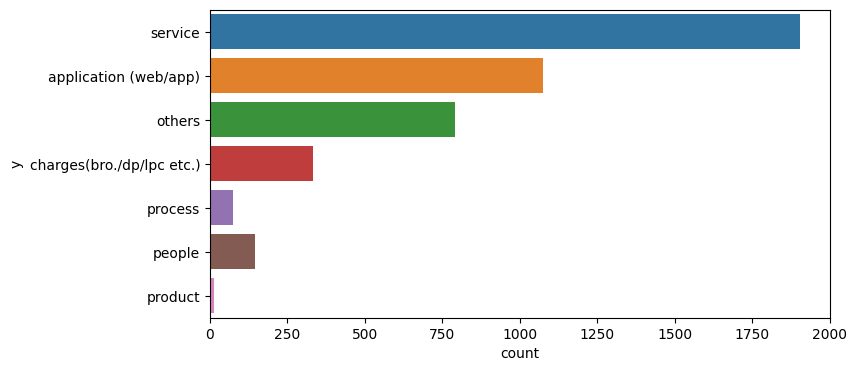

In [9]:
plt.figure(figsize=[8,4])
sns.countplot(y=df['y'])

In [10]:
# Preprocessing

In [11]:
# Remove integer comments
df = df[df['x'].apply(lambda x: not isinstance(x, int))]
df.reset_index(drop=True, inplace=True)

#lower case
df['x'] = df['x'].str.lower()

# Keep only alphabets
def cleaner(text):
    text = re.sub("[^A-Za-z]+", ' ', text)
    return text

In [12]:
df['x'] = df['x'].apply(cleaner)

In [13]:
# re.sub("[^A-Za-z]+", ' ', " qweqw asas/ das 232 ) & g 23esd ")

In [15]:
# Dict for classes
df['category_id'] = df['y'].factorize()[0]
category_id_df = df[['y', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'y']].values)

In [16]:
category_id_df

,y,category_id
0,service,0
1,application (web/app),1
2,others,2
6,charges(bro./dp/lpc etc.),3
26,process,4
42,people,5
1169,product,6


In [17]:
# df = df[df['category_id']==4]

In [18]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=12, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidfVector.fit_transform(df['x']).toarray()
labels = df.category_id
features.shape

(4335, 665)

In [19]:
pd.DataFrame(features.transpose(),index=tfidfVector.get_feature_names_out())

0     1     2     3     4     5     6     7     8     9     10    \
aap          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
able         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
absolutely   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
access       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
account      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
year         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
years        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
yes          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zero         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zerodha      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                11    12    13    14    15    16    17    18    19    \
aap         0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
able        0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
absolutely  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
access      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
account     0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   
year        0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
years       0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
yes         0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zero        0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zerodha     0.160458   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                20        21    22    23    24    25       26    27    28    \
aap         0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
able        0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
absolutely  0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
access      0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
account     0.265356  0.159739   0.0   0.0   0.0   0.0  0.21618   0.0   0.0   
...              ...       ...   ...   ...   ...   ...      ...   ...   ...   
year        0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
years       0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
yes         0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
zero        0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
zerodha     0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   

                29    30    31    32    33        34    35        36    37    \
aap         0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
able        0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.305414   0.0   
absolutely  0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
access      0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
account     0.177372   0.0   0.0   0.0   0.0  0.349277   0.0  0.000000   0.0   
...              ...   ...   ...   ...   ...       ...   ...       ...   ...   
year        0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
years       0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
yes         0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
zero        0.273129   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
zerodha     0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   

            38    39    40    41    42    43    44    45    46    47    48    \
aap          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
able         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
absolutely   0.0   0.0   0.0   0.0  

In [20]:
# smt = SMOTETomek(sampling_strategy = 'auto', random_state=42)
# X, y = smt.fit_resample(features, labels)

In [21]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy='auto',random_state=42,k_neighbors=2)
# X, y = sm.fit_resample(features, labels)

In [22]:
# df_smote = pd.DataFrame(X)

In [23]:
# y.value_counts()

In [24]:
X = features
y = labels

In [25]:
features.shape

(4335, 665)

In [26]:
# We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for i, j in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == j)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfVector.get_feature_names_out())[indices]
    # print(feature_names)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(i))
    # print(feature_names)
    print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'application (web/app)':
 Most correlated unigrams:
. neo
. app
 Most correlated bigrams:
. improve app
. kotak neo
# 'charges(bro./dp/lpc etc.)':
 Most correlated unigrams:
. charges
. brokerage
 Most correlated bigrams:
. high brokerage
. brokerage charges
# 'others':
 Most correlated unigrams:
. ok
. good
 Most correlated bigrams:
. customer service
. customer care
# 'people':
 Most correlated unigrams:
. knowledgeable
. knowledge
 Most correlated bigrams:
. customer support
. proper knowledge
# 'process':
 Most correlated unigrams:
. fund
. process
 Most correlated bigrams:
. solve problem
. trading account
# 'product':
 Most correlated unigrams:
. daily
. recommendations
 Most correlated bigrams:
. till date
. long time
# 'service':
 Most correlated unigrams:
. dealer
. service
 Most correlated bigrams:
. poor service
. customer service


<Axes: xlabel='model_name', ylabel='accuracy'>

<Axes: xlabel='model_name', ylabel='accuracy'>

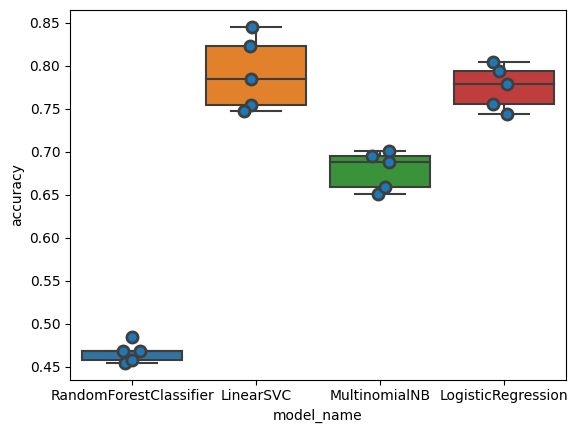

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [28]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
model = LinearSVC(class_weight = 'balanced')
# model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.33, stratify=y, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

LinearSVC(class_weight='balanced')

<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

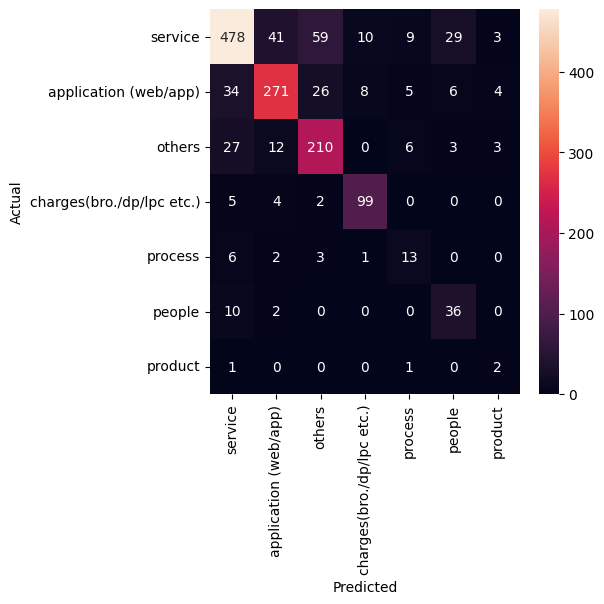

In [29]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [33]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['y'].unique()))

                           precision    recall  f1-score   support

                  service       0.85      0.76      0.80       629
    application (web/app)       0.82      0.77      0.79       354
                   others       0.70      0.80      0.75       261
charges(bro./dp/lpc etc.)       0.84      0.90      0.87       110
                  process       0.38      0.52      0.44        25
                   people       0.49      0.75      0.59        48
                  product       0.17      0.50      0.25         4

                 accuracy                           0.77      1431
                macro avg       0.61      0.71      0.64      1431
             weighted avg       0.79      0.77      0.78      1431



In [30]:
y_pred_overall = model.predict(X)

<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

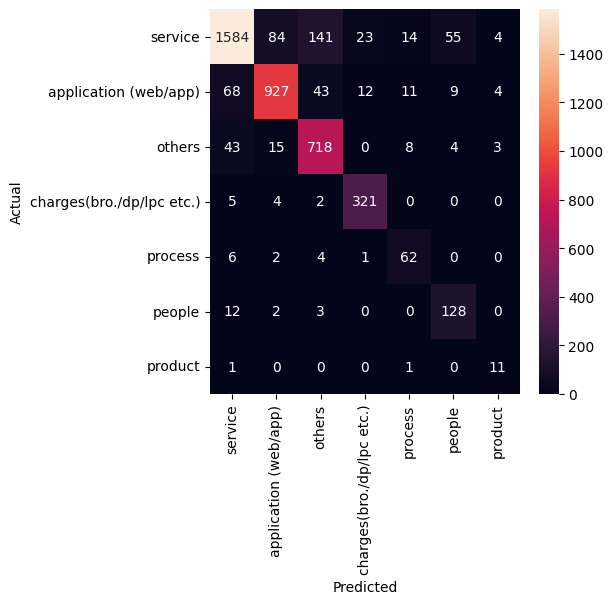

In [31]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y, y_pred_overall)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [32]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(y, y_pred_overall, target_names=df['y'].unique()))

                           precision    recall  f1-score   support

                  service       0.92      0.83      0.87      1905
    application (web/app)       0.90      0.86      0.88      1074
                   others       0.79      0.91      0.84       791
charges(bro./dp/lpc etc.)       0.90      0.97      0.93       332
                  process       0.65      0.83      0.73        75
                   people       0.65      0.88      0.75       145
                  product       0.50      0.85      0.63        13

                 accuracy                           0.87      4335
                macro avg       0.76      0.87      0.80      4335
             weighted avg       0.87      0.87      0.87      4335



In [ ]:
# To manually verify why some failed
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['y', 'x']])
            print('')

'APPLICATION (WEB/APP)' predicted as 'SERVICE' : 31 examples.


,y,x
551,APPLICATION (WEB/APP),ease of working with software is missing
351,APPLICATION (WEB/APP),even till date my trading accounts and demat h...
456,APPLICATION (WEB/APP),there are several bugs kindly fix those specia...
56,APPLICATION (WEB/APP),transparency or honi chiye or aap technically ...
186,APPLICATION (WEB/APP),just improve your platform
171,APPLICATION (WEB/APP),direct debit from kotak savings a c to trading...
247,APPLICATION (WEB/APP),due to technical glitch in app kotak neo i los...
415,APPLICATION (WEB/APP),kindly improve overall experience
482,APPLICATION (WEB/APP),suggestions made before i didnt see improvemen...
34,APPLICATION (WEB/APP),why my account suspendfive days please solve m...



'NOT SPECIFIED' predicted as 'SERVICE' : 21 examples.


,y,x
381,NOT SPECIFIED,sorry you do not have time to attend subscribe...
135,NOT SPECIFIED,kotak have to ban from india
105,NOT SPECIFIED,worst
759,NOT SPECIFIED,wants to close relationship
661,NOT SPECIFIED,pls stop calling
365,NOT SPECIFIED,worsted experience
527,NOT SPECIFIED,bad experience
60,NOT SPECIFIED,not called
691,NOT SPECIFIED,just ok
261,NOT SPECIFIED,worst of the worst



'CHARGES(BRO./DP/LPC ETC.)' predicted as 'SERVICE' : 12 examples.


,y,x
728,CHARGES(BRO./DP/LPC ETC.),employees are unavailable to contact for quarr...
667,CHARGES(BRO./DP/LPC ETC.),as and when there are changes in interest or a...
692,CHARGES(BRO./DP/LPC ETC.),loot by you of account holder very high charge...



'SERVICE' predicted as 'APPLICATION (WEB/APP)' : 28 examples.


,y,x
579,SERVICE,my problems not solved at all call me to know ...
642,SERVICE,worst service unable to convert trade free pla...
440,SERVICE,no demo given even after months of opening hav...
771,SERVICE,the employees are not contacting for any issue...
320,SERVICE,worst service and i lost rupees in two days fo...
17,SERVICE,pathetic if ur management is listening follow ...
372,SERVICE,no response for retail invester
569,SERVICE,pls attend query in time so that problem in tr...
350,SERVICE,need improvement in all departments
659,SERVICE,we need local ref to spell out our quiries



'SERVICE' predicted as 'NOT SPECIFIED' : 38 examples.


,y,x
717,SERVICE,no interactions
166,SERVICE,sack your hr head for employing lazy people ma...
374,SERVICE,acha nahi smjhaya apka admi
721,SERVICE,please honour what you commit
729,SERVICE,interacted not feedback not updation
61,SERVICE,teacher appoint for new playing
497,SERVICE,pathetic advice by ur expert
489,SERVICE,never have interaction with anyone
723,SERVICE,was busy so requested her to call back after m...
711,SERVICE,some senior from mgt to spk pl



'APPLICATION (WEB/APP)' predicted as 'NOT SPECIFIED' : 15 examples.


,y,x
563,APPLICATION (WEB/APP),very bad software
665,APPLICATION (WEB/APP),my positions were diluted due to your pathetic...
172,APPLICATION (WEB/APP),improve tecanical chart and easy to use
773,APPLICATION (WEB/APP),reatime data delayed to reflect on dashboard
28,APPLICATION (WEB/APP),how to set target price is not given executed ...
553,APPLICATION (WEB/APP),totally unsatisfying results
